In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np


# Hardcoded directories for 'yes' and 'no'
yes_dir = '/Users/yannietchi/Desktop/comp-562-final-project/MRI data/yes'
no_dir = '/Users/yannietchi/Desktop/comp-562-final-project/MRI data/no'


Sample images from 'yes' (Tumor) dataset:


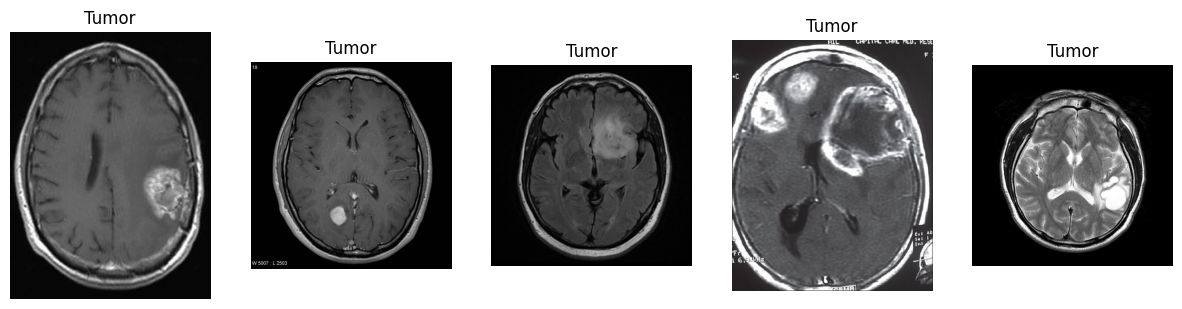

Sample images from 'no' (No Tumor) dataset:


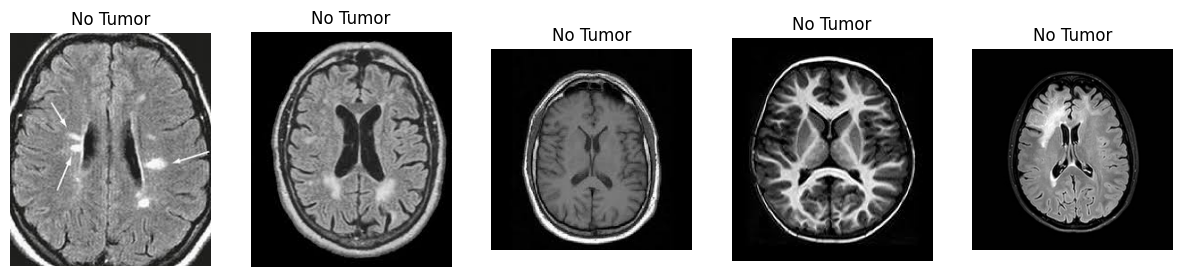

In [4]:


# Function to display sample images from a folder
def display_images(folder, label, n=5):
    # Get all image files from the folder
    image_files = [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
    
    # Select up to `n` images to display
    image_files = image_files[:n]
    
    # Create a figure
    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(image_files):
        img = Image.open(img_path)  # Open the image
        plt.subplot(1, n, i + 1)    # Add a subplot
        plt.imshow(img, cmap='gray')  # Display the image
        plt.title(label)  # Title as the label
        plt.axis('off')   # Turn off axes
    plt.show()


# Display sample images from 'yes' and 'no'
print("Sample images from 'yes' (Tumor) dataset:")
display_images(yes_dir, label="Tumor")

print("Sample images from 'no' (No Tumor) dataset:")
display_images(no_dir, label="No Tumor")


In [5]:
image_paths = []
labels = []

# Process 'yes' folder
for filename in os.listdir(yes_dir):
    file_path = os.path.join(yes_dir, filename)
    if os.path.isfile(file_path):  # Ensure it's a file
        image_paths.append(file_path)
        labels.append(1)  # Label for tumor

# Process 'no' folder
for filename in os.listdir(no_dir):
    file_path = os.path.join(no_dir, filename)
    if os.path.isfile(file_path):  # Ensure it's a file
        image_paths.append(file_path)
        labels.append(0)  # Label for no tumor

# Create the dataframe
data = pd.DataFrame({'image_path': image_paths, 'label': labels})

# Display the first few rows

data


,image_path,label
0,/Users/yannietchi/Desktop/comp-562-final-proje...,1
1,/Users/yannietchi/Desktop/comp-562-final-proje...,1
2,/Users/yannietchi/Desktop/comp-562-final-proje...,1
3,/Users/yannietchi/Desktop/comp-562-final-proje...,1
4,/Users/yannietchi/Desktop/comp-562-final-proje...,1
...,...,...
248,/Users/yannietchi/Desktop/comp-562-final-proje...,0
249,/Users/yannietchi/Desktop/comp-562-final-proje...,0
250,/Users/yannietchi/Desktop/comp-562-final-proje...,0
251,/Users/yannietchi/Desktop/comp-562-final-proje...,0


<h2> Data Augmentation</h2>

In [6]:

# Define data augmentation for grayscale images
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Function to load and augment images
def augment_images(folder, label, augmentor, num_augments=3):
    data = []
    for file in os.listdir(folder):
        img_path = os.path.join(folder, file)
        if os.path.isfile(img_path):
            # Load and preprocess image
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img = np.array(img).reshape((1, img.size[1], img.size[0], 1))  # Reshape for augmentation
            
            # Append original image to data
            data.append({'image': img.squeeze(), 'label': label})

            # Generate augmented images
            aug_iter = augmentor.flow(img, batch_size=1)
            for _ in range(num_augments):
                aug_img = next(aug_iter)[0].squeeze()
                data.append({'image': aug_img, 'label': label})
    return data



# Augment images in both folders
yes_data = augment_images(yes_dir, 1, datagen, num_augments=3)  # Tumor label is 1
no_data = augment_images(no_dir, 0, datagen, num_augments=3)    # No-tumor label is 0

# Combine data into a DataFrame
data_augmented = yes_data + no_data
df_augmented = pd.DataFrame(data_augmented)

# Example: Display first few rows of the DataFrame
df_augmented


,image,label
0,"[[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,...",1
1,"[[6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0,...",1
2,"[[6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0,...",1
3,"[[6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0,...",1
4,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",1
...,...,...
1007,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
1008,"[[28, 29, 0, 2, 0, 3, 0, 1, 0, 0, 0, 0, 0, 0, ...",0
1009,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
1010,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0


In [7]:
from tensorflow.image import resize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
from PIL import Image
import os
import random

# Set the target size for images
target_size = (64, 64)

# Augmentation setup
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create a DataFrame to store image and label
augmented_images = []

# Loop through the original 'yes' and 'no' folders and augment images
def augment_images_from_folder(folder, label):
    for filename in os.listdir(folder):
        if filename.endswith('.png') or filename.endswith('.jpg'):
            # Open the image
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img = np.array(img)
            
            # Standardize shape to target size (e.g., 64x64)
            img_resized = resize(np.expand_dims(img, axis=-1), target_size).numpy()

            # Perform augmentation
            img_reshaped = img_resized.reshape((1,) + img_resized.shape)  # Reshape for augmentation
            it = datagen.flow(img_reshaped, batch_size=1)

            # Store augmented images and their labels
            for _ in range(5):  # Augment and store 5 versions per image
                augmented_img = next(it)[0].astype(np.uint8)  # Get the augmented image
                augmented_images.append([augmented_img, label])


# Augment images from 'yes' and 'no' folders
augment_images_from_folder(yes_dir, 1)  # Tumor label = 1
augment_images_from_folder(no_dir, 0)  # No tumor label = 0

# Convert to DataFrame
df_augmented = pd.DataFrame(augmented_images, columns=['image', 'label'])

# Show a sample from the dataframe (e.g., first 3 images)
df_augmented.head(3)




,image,label
0,"[[[1], [1], [1], [1], [1], [1], [1], [1], [1],...",1
1,"[[[1], [1], [1], [1], [1], [1], [1], [1], [1],...",1
2,"[[[1], [1], [1], [1], [1], [1], [1], [1], [1],...",1


<h2> Baseline Model<h2>

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers.legacy import Adam
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D


# Assuming df_augmented is already created as shown in the previous steps
X = np.array([np.expand_dims(img, axis=-1) for img in df_augmented['image']])  # Shape: (n_samples, 64, 64, 1)
y = np.array(df_augmented['label'])  # Labels: 0 or 1

# First split the data into training and temporary (for validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Now split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)



Epoch 1/50
22/22 [==============================] - 3s 102ms/step - loss: 0.7635 - accuracy: 0.4740 - val_loss: 0.7460 - val_accuracy: 0.5349
Epoch 2/50
22/22 [==============================] - 2s 83ms/step - loss: 0.7251 - accuracy: 0.5332 - val_loss: 0.6942 - val_accuracy: 0.5233
Epoch 3/50
22/22 [==============================] - 4s 191ms/step - loss: 0.7315 - accuracy: 0.5130 - val_loss: 0.6813 - val_accuracy: 0.5116
Epoch 4/50
22/22 [==============================] - 4s 178ms/step - loss: 0.7391 - accuracy: 0.5275 - val_loss: 0.6765 - val_accuracy: 0.5233
Epoch 5/50
22/22 [==============================] - 4s 175ms/step - loss: 0.7136 - accuracy: 0.5708 - val_loss: 0.6756 - val_accuracy: 0.5698
Epoch 6/50
22/22 [==============================] - 4s 175ms/step - loss: 0.6852 - accuracy: 0.5997 - val_loss: 0.6726 - val_accuracy: 0.5465
Epoch 7/50
22/22 [==============================] - 4s 176ms/step - loss: 0.6752 - accuracy: 0.6272 - val_loss: 0.6704 - val_accuracy: 0.5233
Epoch 8

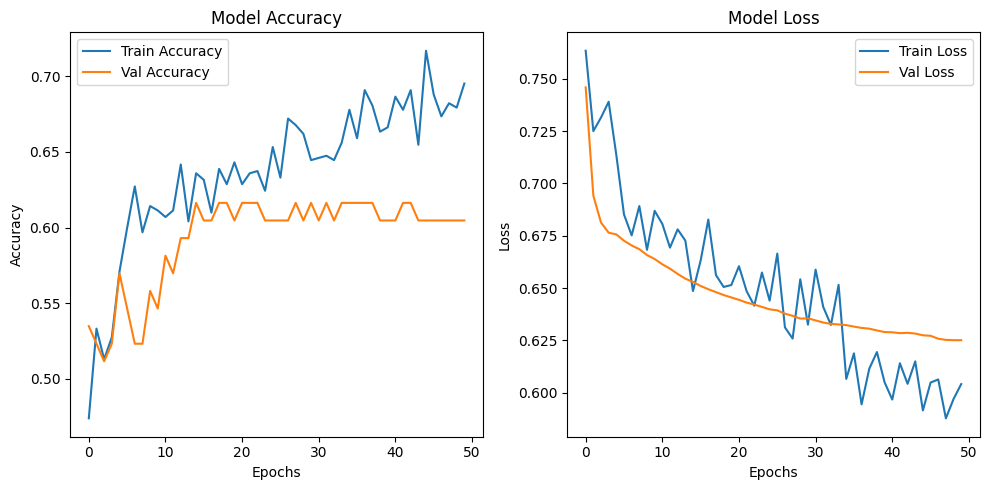

In [23]:
# Define CNN model architecture

def baseline_cnn_model(input_shape=(64, 64, 1)):
    model = Sequential()
    
    # First convolutional block
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    
    # Second convolutional block
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    
    # Third convolutional block
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))
    
    # Global average pooling to reduce dimensions and avoid overfitting
    model.add(GlobalAveragePooling2D())
    
    # Fully connected layer
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))  # For binary classification (tumor vs non-tumor)
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model


# Create CNN model
baseline_model = baseline_cnn_model()

# Train the model
history = baseline_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=1)

# Plot the learning curves
plt.figure(figsize=(10, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

baseline_model.save('./baseline_model.keras')




<h2> Test<h3>

In [18]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, X_test, y_test, threshold=0.5):
    
    # Predict probabilities or labels
    y_pred_prob = model.predict(X_test)
    
    # For binary classification, convert probabilities to labels
    if y_pred_prob.shape[1] == 1:  # Binary classification
        y_pred = (y_pred_prob > threshold).astype(int)
    else:  # For multi-class classification
        y_pred = np.argmax(y_pred_prob, axis=1)

    # Classification Report
    print("Classification Report:\n", classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Create a 1x2 subplot layout (side-by-side)
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Tumor', 'Tumor'], yticklabels=['Non-Tumor', 'Tumor'], ax=axes[0])
    axes[0].set_title('Confusion Matrix')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')
    
    # ROC Curve
    if y_pred_prob.shape[1] == 1:  # Binary classification
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        
        axes[1].plot(fpr, tpr, color='b', label=f'ROC Curve (AUC = {roc_auc:.2f})')
        axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--')
        axes[1].set_title('Receiver Operating Characteristic (ROC) Curve')
        axes[1].set_xlabel('False Positive Rate')
        axes[1].set_ylabel('True Positive Rate')
        axes[1].legend(loc='lower right')
    else:
        axes[1].text(0.5, 0.5, "ROC curve is only applicable for binary classification.", horizontalalignment='center', verticalalignment='center', fontsize=12)
        axes[1].axis('off')

    # Show the plots
    plt.tight_layout()
    plt.show()



3/3 [==============================] - 0s 21ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.72      0.70        43
           1       0.71      0.66      0.68        44

    accuracy                           0.69        87
   macro avg       0.69      0.69      0.69        87
weighted avg       0.69      0.69      0.69        87



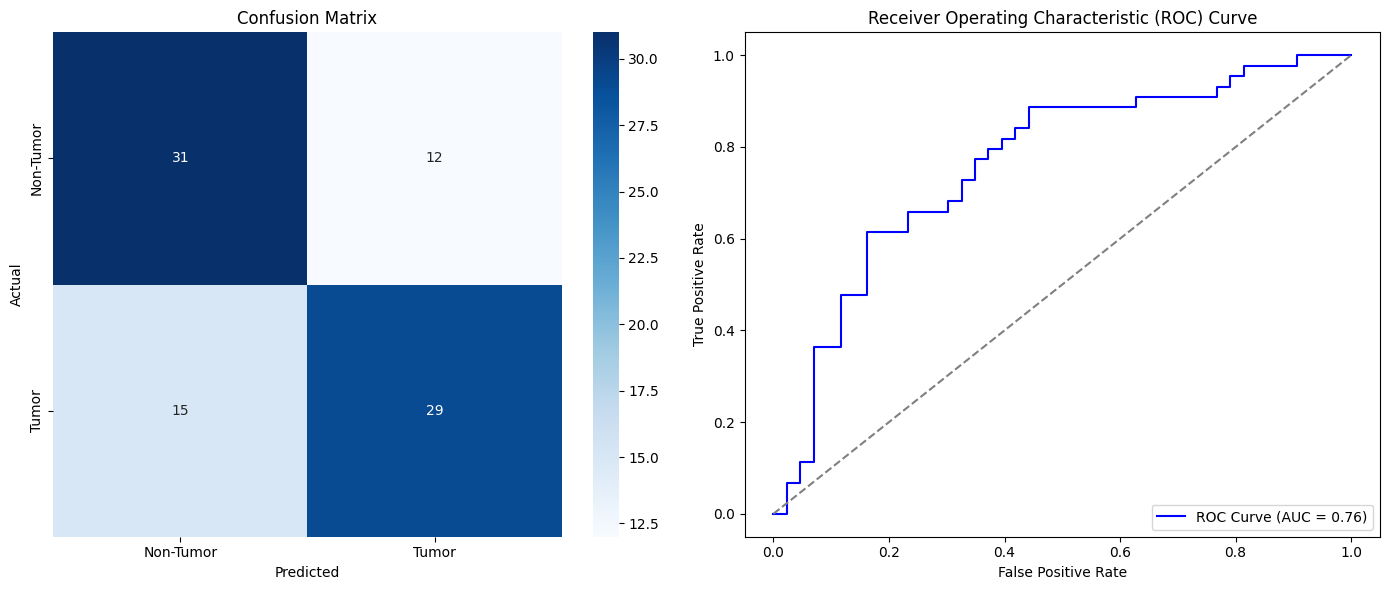

In [14]:
evaluate_model(baseline_model,X_test,y_test)

1/1 [==============================] - 0s 103ms/step


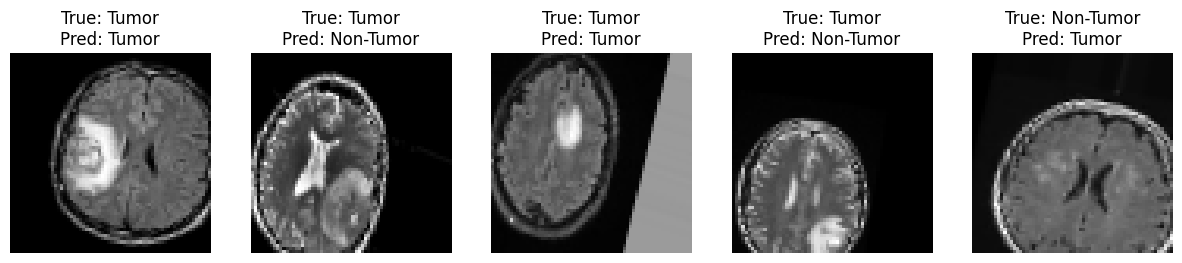

(87, 64, 64, 1, 1)

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def show_predictions(model, X, y, num_samples=5):

    # Remove extra singleton dimensions (if any)
    X = np.squeeze(X)

    # Generate predictions
    y_pred = model.predict(X[:num_samples])

    # Plot the images with true and predicted labels
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        
        # Ensure the image is in the correct format for displaying (height, width, channels)
        img = X[i]
        
        # Check if it's a grayscale or RGB image and process accordingly
        if img.ndim == 2:  # Grayscale image
            plt.imshow(img, cmap='gray')
        else:  # RGB image
            plt.imshow(img)
        
        plt.title(f"True: {'Tumor' if y[i] == 1 else 'Non-Tumor'}\nPred: {'Tumor' if y_pred[i] > 0.5 else 'Non-Tumor'}")
        plt.axis('off')
    
    plt.show()

# Example usage:
show_predictions(baseline_model, X_test, y_test, num_samples=5)

X_test.shape

<h2> Hyperparameter tuning<h2>

Trial 10 Complete [00h 11m 36s]
val_accuracy: 0.7790697813034058

Best val_accuracy So Far: 0.8720930218696594
Total elapsed time: 02h 18m 22s


Best Hyperparameters: {'filters_1': 128, 'dropout_1': 0.2, 'filters_2': 64, 'dropout_2': 0.2, 'filters_3': 384, 'dropout_3': 0.3, 'dense_units': 256, 'dropout_4': 0.3, 'learning_rate': 0.0057472709072909165}
Epoch 1/50
22/22 [==============================] - 23s 1s/step - loss: 0.2422 - accuracy: 0.9104 - val_loss: 0.2983 - val_accuracy: 0.8488
Epoch 2/50
22/22 [==============================] - 13s 580ms/step - loss: 0.2725 - accuracy: 0.8887 - val_loss: 0.7013 - val_accuracy: 0.7558
Epoch 3/50
22/22 [==============================] - 12s 555ms/step - loss: 0.2129 - accuracy: 0.9147 - val_loss: 0.7646 - val_accuracy: 0.7093
Epoch 4/50
22/22 [==============================] - 13s 584ms/step - loss: 0.1599 - accuracy: 0.9350 - val_loss: 0.2496 - val_accuracy: 0.8721
Epoch 5/50
22/22 [==============================] - 14s 623ms/step - loss: 0.1671 - accuracy: 0.9306 - val_loss: 0.5580 - val_accuracy: 0.8140
Epoch 6/50
22/22 [==============================] - 19s 858ms/step - loss: 0.135

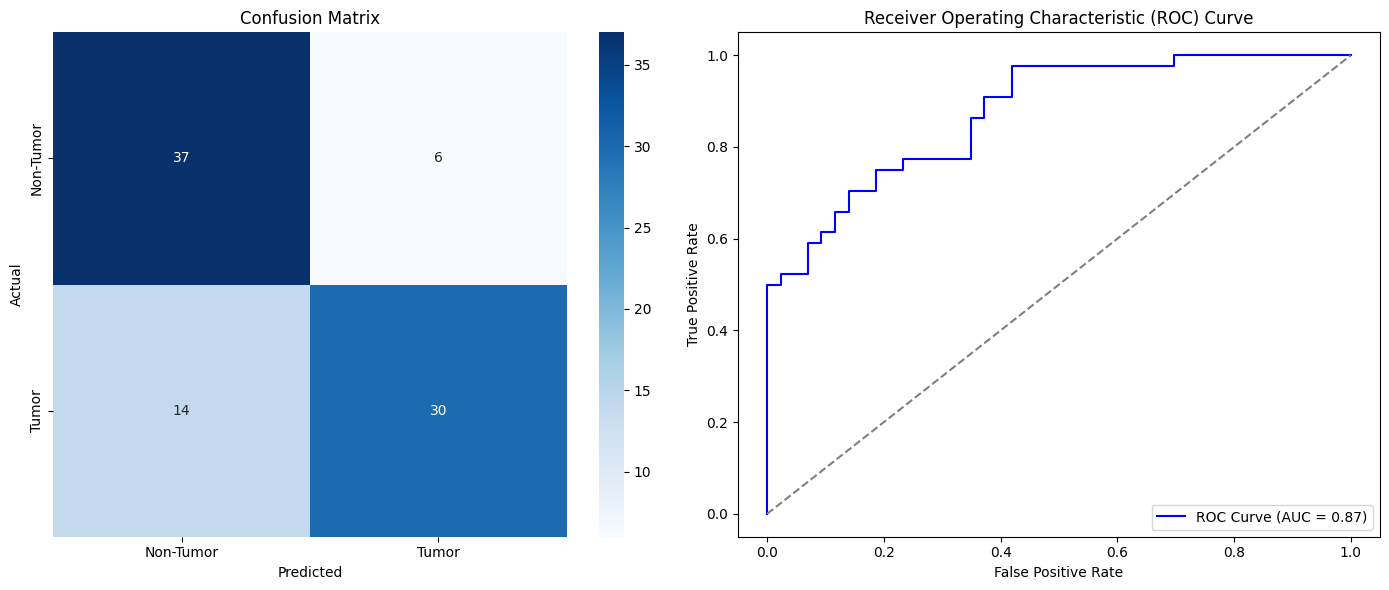

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

# Define the CNN model with hyperparameters
def baseline_cnn_model(hp, input_shape=(64, 64, 1)):
    model = Sequential()
    
    # First convolutional block with hyperparameters for filters and dropout rate
    model.add(Conv2D(hp.Int('filters_1', min_value=32, max_value=128, step=32), 
                     (3, 3), 
                     activation='relu', 
                     padding='same', 
                     input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))
    
    # Second convolutional block
    model.add(Conv2D(hp.Int('filters_2', min_value=64, max_value=256, step=64), 
                     (3, 3), 
                     activation='relu', 
                     padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))
    
    # Third convolutional block
    model.add(Conv2D(hp.Int('filters_3', min_value=128, max_value=512, step=128), 
                     (3, 3), 
                     activation='relu', 
                     padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(hp.Float('dropout_3', min_value=0.3, max_value=0.6, step=0.1)))
    
    # Global average pooling to reduce dimensions and avoid overfitting
    model.add(GlobalAveragePooling2D())
    
    # Fully connected layer with hyperparameter for units and dropout rate
    model.add(Dense(hp.Int('dense_units', min_value=64, max_value=256, step=64), activation='relu'))
    model.add(Dropout(hp.Float('dropout_4', min_value=0.3, max_value=0.6, step=0.1)))
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))  # For binary classification (tumor vs non-tumor)
    
    # Compile the model with hyperparameter tuning for learning rate
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# Setup Keras Tuner for hyperparameter search
def hyperparameter_tuning(X_train, y_train, X_val, y_val):
    tuner = kt.RandomSearch(
        baseline_cnn_model,
        objective='val_accuracy',
        max_trials=10,  # Number of different hyperparameter combinations to try
        executions_per_trial=1,
        directory='tuner_dir',
        project_name='cnn_hyperparam_tuning'
    )
    
    # Perform hyperparameter search
    tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)
    
    # Get the best model and hyperparameters
    best_model = tuner.get_best_models()[0]
    best_hyperparameters = tuner.get_best_hyperparameters()[0]
    
    print(f"Best Hyperparameters: {best_hyperparameters.values}")
    
    return best_model

# Train and evaluate the best model
def train_and_evaluate_model(X_train, y_train, X_val, y_val, X_test, y_test):
    # Run hyperparameter tuning
    best_model = hyperparameter_tuning(X_train, y_train, X_val, y_val)
    
    # Evaluate the best model on test data
    history = best_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)
    
    # Evaluate on test set
    test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
    print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")
    
    # Use your previous evaluation function to plot confusion matrix and ROC curve

    
    evaluate_model(best_model, X_test, y_test)
    
    # Return the best model and training history
    return best_model, history

# Assuming X_train, y_train, X_val, y_val, X_test, y_test are already prepared
best_model, history = train_and_evaluate_model(X_train, y_train, X_val, y_val, X_test, y_test)


In [23]:

best_model.save('./finetuned_model.keras')


<h2>Pre trained model Resnet 50<h2>

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Adjust input shape to match ResNet requirements
input_shape = (64, 64, 3)  # ResNet expects 3 channels

X_train = np.squeeze(X_train, axis=-1)  # Remove the last dimension
X_val = np.squeeze(X_val, axis=-1)
X_test = np.squeeze(X_test, axis=-1)

X_train_rgb = np.repeat(X_train, 3, axis=-1)  # (692, 64, 64, 1) -> (692, 64, 64, 3)
X_val_rgb = np.repeat(X_val, 3, axis=-1)
X_test_rgb = np.repeat(X_test, 3, axis=-1)

# Load pretrained ResNet50 with weights from ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for fine-tuning
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the model
resnet_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
resnet_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = resnet_model.fit(
    X_train_rgb, y_train,
    validation_data=(X_val_rgb, y_val),
    epochs=20,
    batch_size=32,
    verbose=1
)

# Unfreeze some layers for fine-tuning
for layer in base_model.layers[-20:]:  # Unfreeze last 20 layers
    layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
resnet_model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

# Fine-tune the model
history_fine_tune = resnet_model.fit(
    X_train_rgb, y_train,
    validation_data=(X_val_rgb, y_val),
    epochs=20,
    batch_size=32,
    verbose=1
)

# Evaluate on test set
results = resnet_model.evaluate(X_test_rgb, y_test, verbose=1)
print(f"Test Accuracy: {results[1] * 100:.2f}%")




Epoch 1/20
22/22 [==============================] - 11s 396ms/step - loss: 1.2011 - accuracy: 0.6098 - val_loss: 0.6500 - val_accuracy: 0.6860
Epoch 2/20
22/22 [==============================] - 7s 326ms/step - loss: 0.6505 - accuracy: 0.7298 - val_loss: 0.5923 - val_accuracy: 0.7442
Epoch 3/20
22/22 [==============================] - 7s 315ms/step - loss: 0.6261 - accuracy: 0.7587 - val_loss: 0.5500 - val_accuracy: 0.7674
Epoch 4/20
22/22 [==============================] - 7s 333ms/step - loss: 0.4495 - accuracy: 0.8165 - val_loss: 0.4989 - val_accuracy: 0.7791
Epoch 5/20
22/22 [==============================] - 7s 320ms/step - loss: 0.4423 - accuracy: 0.8121 - val_loss: 0.4968 - val_accuracy: 0.7791
Epoch 6/20
22/22 [==============================] - 7s 322ms/step - loss: 0.3553 - accuracy: 0.8353 - val_loss: 0.4577 - val_accuracy: 0.8023
Epoch 7/20
22/22 [==============================] - 7s 323ms/step - loss: 0.3372 - accuracy: 0.8584 - val_loss: 0.4457 - val_accuracy: 0.8256
Epoch

NameError: name 'evaluate_model' is not defined

3/3 [==============================] - 1s 127ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.91      0.86        43
           1       0.90      0.80      0.84        44

    accuracy                           0.85        87
   macro avg       0.85      0.85      0.85        87
weighted avg       0.86      0.85      0.85        87



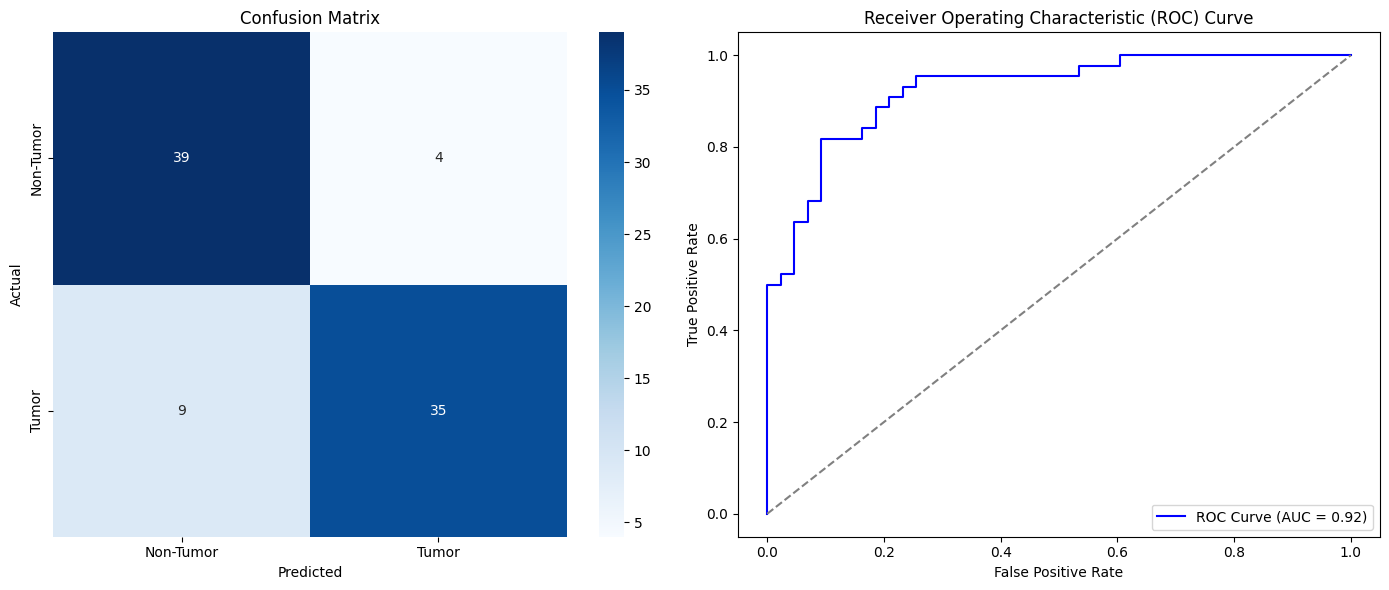

In [19]:
# Use evaluation function for metrics and visualizations
evaluate_model(resnet_model, X_test_rgb, y_test)

resnet_model.save('./resnet_model.keras')

<h2>VGG<h2>

Epoch 1/20
22/22 [==============================] - 18s 792ms/step - loss: 5.8054 - accuracy: 0.5246 - val_loss: 1.5412 - val_accuracy: 0.7326
Epoch 2/20
22/22 [==============================] - 19s 887ms/step - loss: 3.4765 - accuracy: 0.6691 - val_loss: 1.4337 - val_accuracy: 0.8023
Epoch 3/20
22/22 [==============================] - 20s 926ms/step - loss: 2.6054 - accuracy: 0.7052 - val_loss: 1.3322 - val_accuracy: 0.7907
Epoch 4/20
22/22 [==============================] - 20s 904ms/step - loss: 2.2957 - accuracy: 0.7500 - val_loss: 1.2653 - val_accuracy: 0.8256
Epoch 5/20
22/22 [==============================] - 20s 900ms/step - loss: 1.6504 - accuracy: 0.8150 - val_loss: 1.1863 - val_accuracy: 0.8140
Epoch 6/20
22/22 [==============================] - 26s 1s/step - loss: 1.5627 - accuracy: 0.8078 - val_loss: 1.0699 - val_accuracy: 0.8488
Epoch 7/20
22/22 [==============================] - 20s 912ms/step - loss: 1.3226 - accuracy: 0.8223 - val_loss: 1.0869 - val_accuracy: 0.8605
Ep

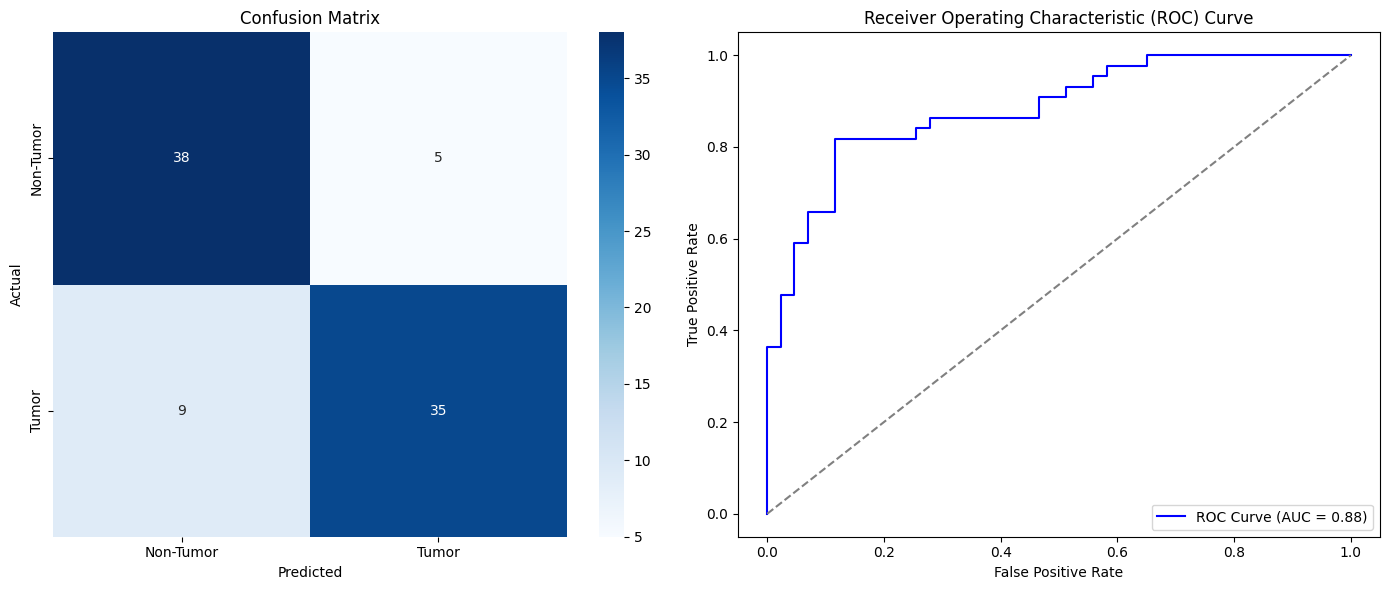

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load the VGG16 model with pre-trained ImageNet weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze the base model layers for initial training
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for binary classification
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification output

# Create the final model
vgg_model = Model(inputs=base_model.input, outputs=output)

# Compile the model
vgg_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with the base layers frozen
history = vgg_model.fit(
    X_train_rgb, y_train,
    validation_data=(X_val_rgb, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping],   
    verbose=1
)

# Fine-tuning: Unfreeze some layers
for layer in base_model.layers[-20:]:  # Unfreeze last 20 layers
    layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
vgg_model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Fine-tune the model
history_fine_tune = vgg_model.fit(
    X_train_rgb, y_train,
    validation_data=(X_val_rgb, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping],   
    verbose=1
)

# Evaluate the model on the test set
evaluate_model(vgg_model, X_test_rgb, y_test)

# Save the fine-tuned model


In [22]:
vgg_model.save('./vgg_model.keras')

3/3 [==============================] - 0s 23ms/step


3/3 [==============================] - 1s 228ms/step


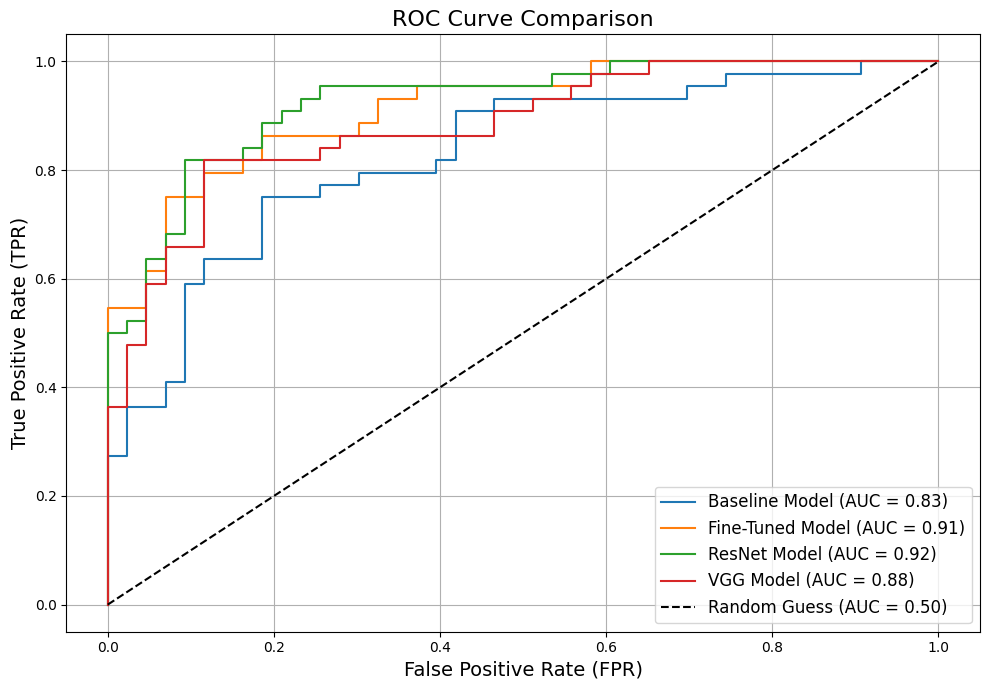

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import load_model

# Function to compute ROC and AUC for a model
def compute_roc_auc(model_path, X_test, y_test, use_rgb=False):
    model = load_model(model_path)  # Load the model
    X = X_test_rgb if use_rgb else X_test  # Select the appropriate test data
    y_pred_prob = model.predict(X)  # Predict probabilities
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc

# Specify models and whether they require RGB input
models = {
    "Baseline Model": {"path": "./models/baseline_model.keras", "use_rgb": False},
    "Fine-Tuned Model": {"path": "./models/finetuned_model.keras", "use_rgb": False},
    "ResNet Model": {"path": "./models/resnet_model.keras", "use_rgb": True},
    "VGG Model": {"path": "./models/vgg_model.keras", "use_rgb": True},
}

plt.figure(figsize=(10, 7))
for model_name, details in models.items():
    fpr, tpr, roc_auc = compute_roc_auc(
        details["path"], X_test, y_test, use_rgb=details["use_rgb"]
    )
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")

# Plot aesthetics
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess (AUC = 0.50)")
plt.title("ROC Curve Comparison", fontsize=16)
plt.xlabel("False Positive Rate (FPR)", fontsize=14)
plt.ylabel("True Positive Rate (TPR)", fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

3/3 [==============================] - 0s 20ms/step


3/3 [==============================] - 1s 232ms/step


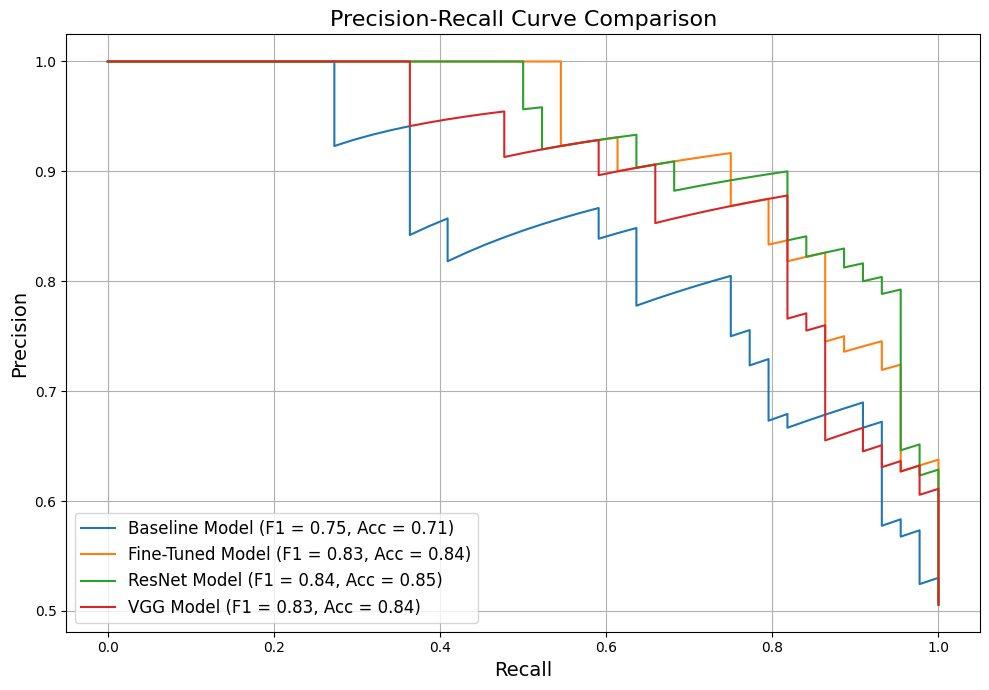

==== Baseline Model ====
F1 Score: 0.75
Accuracy: 0.71
Classification Report:
{'0': {'precision': 0.78125, 'recall': 0.5813953488372093, 'f1-score': 0.6666666666666666, 'support': 43.0}, '1': {'precision': 0.6727272727272727, 'recall': 0.8409090909090909, 'f1-score': 0.7474747474747475, 'support': 44.0}, 'accuracy': 0.7126436781609196, 'macro avg': {'precision': 0.7269886363636364, 'recall': 0.7111522198731501, 'f1-score': 0.7070707070707071, 'support': 87.0}, 'weighted avg': {'precision': 0.7263649425287356, 'recall': 0.7126436781609196, 'f1-score': 0.7075351213282248, 'support': 87.0}}

==== Fine-Tuned Model ====
F1 Score: 0.83
Accuracy: 0.84
Classification Report:
{'0': {'precision': 0.8085106382978723, 'recall': 0.8837209302325582, 'f1-score': 0.8444444444444444, 'support': 43.0}, '1': {'precision': 0.875, 'recall': 0.7954545454545454, 'f1-score': 0.8333333333333334, 'support': 44.0}, 'accuracy': 0.8390804597701149, 'macro avg': {'precision': 0.8417553191489362, 'recall': 0.8395877

In [27]:
from sklearn.metrics import precision_recall_curve, f1_score, accuracy_score, classification_report
import matplotlib.pyplot as plt

# Function to compute metrics for a model
def compute_metrics(model_path, X_test, y_test, use_rgb=False):
    model = load_model(model_path)  # Load the model
    X = X_test_rgb if use_rgb else X_test  # Select the appropriate test data
    y_pred_prob = model.predict(X)  # Predict probabilities
    y_pred_class = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary class predictions
    
    # Precision-Recall data
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
    f1 = f1_score(y_test, y_pred_class)
    accuracy = accuracy_score(y_test, y_pred_class)
    report = classification_report(y_test, y_pred_class, output_dict=True)
    
    return precision, recall, thresholds, f1, accuracy, report

# Store models and their input format
models = {
    "Baseline Model": {"path": "./models/baseline_model.keras", "use_rgb": False},
    "Fine-Tuned Model": {"path": "./models/finetuned_model.keras", "use_rgb": False},
    "ResNet Model": {"path": "./models/resnet_model.keras", "use_rgb": True},
    "VGG Model": {"path": "./models/vgg_model.keras", "use_rgb": True},
}

# Plot Precision-Recall Curves
plt.figure(figsize=(10, 7))
metrics_summary = {}

for model_name, details in models.items():
    precision, recall, _, f1, accuracy, report = compute_metrics(
        details["path"], X_test, y_test, use_rgb=details["use_rgb"]
    )
    metrics_summary[model_name] = {"F1 Score": f1, "Accuracy": accuracy, "Report": report}
    
    # Plot the Precision-Recall Curve
    plt.plot(recall, precision, label=f"{model_name} (F1 = {f1:.2f}, Acc = {accuracy:.2f})")

# Add plot aesthetics
plt.title("Precision-Recall Curve Comparison", fontsize=16)
plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.legend(loc="lower left", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Print metrics for comparison
for model_name, metrics in metrics_summary.items():
    print(f"==== {model_name} ====")
    print(f"F1 Score: {metrics['F1 Score']:.2f}")
    print(f"Accuracy: {metrics['Accuracy']:.2f}")
    print("Classification Report:")
    print(metrics["Report"])
    print()